### Mean NDVI in polygons

Process
 - Make some random polys in a region near Mt. Rainier NP
 - Find Landsat imagery between 2022 and 2025
 - For each image: calculate NDVI, get mean within polygons

In [1]:
%%capture
# Only necessary if running on cryo image that doesn't have these things.
!pip install xvec rioxarray xarray-spatial exactextract

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import earthaccess
import pandas as pd
import geopandas as gpd
import rasterio
import rioxarray
import xvec
import dask
import shapely
assert(earthaccess.login(strategy="netrc").authenticated)

**Make polygons**

Not perfect circles in my use case but similar size.

In [3]:
n_polygons = 1000
pt_radius = 1000 # m
bbox_3857 = [-13571302.7073,5853627.9860,-13418428.6507,5966199.5809]
bbox_4326 = rasterio.warp.transform_bounds(3857, 4326, *bbox_3857)

point_x = np.random.uniform(bbox_3857[0], bbox_3857[2], size=n_polygons)
point_y = np.random.uniform(bbox_3857[1], bbox_3857[3], size=n_polygons)

polys = [shapely.buffer(shapely.Point(x, y), pt_radius) for x, y in zip(point_x, point_y)]
# all granules are in UTM 10N
polys = gpd.GeoSeries(polys).set_crs(3857).to_crs(32610)
polys.explore()

**Find granules**

Search for granules in the Landsat collection in this area.

In [4]:
def extract_date(g):
    return pd.to_datetime(g["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"][:10], format="%Y-%m-%d")

granules = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=bbox_4326,
    temporal=("2022-01-01", "2025-01-01")
)

allow_months = [6, 7, 8] # summer only

granules = list(filter(lambda g: extract_date(g).month in allow_months, granules))
print(len(granules))

262


**Calculate NDVI**

First set up the process for one granule.

In [5]:
gdal_config = {
    'GDAL_HTTP_COOKIEFILE': '~/cookies.txt',
    'GDAL_HTTP_COOKIEJAR': '~/cookies.txt',
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'TIF',
    'GDAL_HTTP_UNSAFESSL': 'YES',
    'GDAL_HTTP_MAX_RETRY': '10',
    'GDAL_HTTP_RETRY_DELAY': '0.5',
    'VSI_CACHE': 'FALSE',
    'CPL_VSIL_CURL_NON_CACHED': '/vsicurl/https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/',
    'GDAL_CACHEMAX': 0
}
gdal_env = rasterio.env.Env(**gdal_config)

In [6]:
def granule_zonal_statistics(granule):
    # Open files - but lazily
    data_urls = [item["URL"] for item in granule["umm"]["RelatedUrls"]]
    b5_link = next(filter(lambda x: x.endswith("B05.tif") and x.startswith("https"), data_urls))
    b4_link = next(filter(lambda x: x.endswith("B04.tif") and x.startswith("https"), data_urls))
    b5 = rioxarray.open_rasterio(b5_link, cache=False).squeeze(drop=True)
    b4 = rioxarray.open_rasterio(b4_link, cache=False).squeeze(drop=True)
    
    # Determine the region we need to extract
    featurebox = shapely.geometry.box(*polys.total_bounds)
    rasterbox = shapely.geometry.box(*b5.rio.bounds())
    intersect = shapely.intersection(featurebox, rasterbox)
    
    region = intersect.bounds
    
    # extract
    b5_clip = b5.rio.clip_box(*region)
    b4_clip = b4.rio.clip_box(*region)    
    features = polys.cx[region[0]:region[2], region[1]:region[3]]
    
    # replace fills with nan
    b5_nonan = b5_clip.where(b5_clip != b5_clip.attrs["_FillValue"])
    b4_nonan = b4.where(b4_clip != b4_clip.attrs["_FillValue"])
    
    # calculate ndvi
    ndvi = ((b5_nonan - b4_nonan) / (b5_nonan + b4_nonan)).clip(-1, 1)
    
    # add date - some coordinate other than x/y is necessary for
    # exactextract to work
    ndvi = ndvi.assign_coords(date = extract_date(granule)).expand_dims(dim="date")
    
    # get zonal statistics
    zs_da = ndvi.xvec.zonal_stats(
        features.geometry,
        "x", "y",
        method="exactextract"
    )

    # or return dummy data for testing
    '''
    zs_da = xr.DataArray(
        data=np.random.random(features.geometry.size),
        coords=dict(geometry=features.geometry),
        dims=("geometry",)
    )
    '''

    # Close datasets
    ndvi = None
    b4_nonan, b5_nonan = None, None
    b4_clip, b5_clip = None, None
    b4, b5 = None, None
    
    # we can just keep the index of the geodataframe instead of keeping
    # all the geoms as a pandas index
    return xr.Dataset({"mean_ndvi": zs_da})\
        .reset_index("geometry", drop=True)\
        .reindex(geometry=zs_da.index)\
        .drop_vars("index")
    

In [7]:
# test
with gdal_env:
    granule_zs = granule_zonal_statistics(granules[0])
granule_zs

/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


<xarray.Dataset> Size: 6kB
Dimensions:    (date: 1, geometry: 373)
Coordinates:
  * date       (date) datetime64[ns] 8B 2022-06-02
  * geometry   (geometry) int64 3kB 0 1 3 5 6 11 14 ... 986 991 992 993 994 997
Data variables:
    mean_ndvi  (geometry, date) float64 3kB -0.002872 0.1354 ... 0.2575 nan

**Run via dask**

I was able to get this to work by restarting workers every few minutes so they don't run out of memory.

In [8]:
import warnings
import ctypes
import gc
from dask.distributed import Client, LocalCluster, progress

def trim_memory():
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

def worker_driver(granule):
    # Since workers may have restarted, re-import libraries
    # to make sure we are logged in and have the xvec
    # accessor.
    import xvec
    import earthaccess
    assert(earthaccess.login(strategy="netrc").authenticated)
    warnings.filterwarnings("ignore", message="exceptions", category=FutureWarning)
    warnings.filterwarnings("ignore", message="Spatial reference", category=RuntimeWarning)
    
    with gdal_env:
        r = granule_zonal_statistics(granule)

    trim_memory()
    gc.collect()
    
    return r
    
client = Client(
    threads_per_worker=1, 
    n_workers=8, 
    memory_limit="2 GiB", 
    lifetime="5 minutes", 
    lifetime_restart=True,
    lifetime_stagger="5 minutes"
)

lazy_zs = []
for granule in granules:
    this_lazy_zs = dask.delayed(worker_driver)(granule)
    lazy_zs.append(this_lazy_zs)

client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33519 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/s-kganz/proxy/33519/status,
Dashboard: /user/s-kganz/proxy/33519/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43193,Workers: 8
Dashboard: /user/s-kganz/proxy/33519/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:40633,Total threads: 1
Dashboard: /user/s-kganz/proxy/42083/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:41333,


2025-05-07 16:16:39,912 - distributed.nanny - WARNING - Restarting worker
2025-05-07 16:17:27,740 - distributed.nanny - WARNING - Restarting worker
2025-05-07 16:17:36,275 - distributed.nanny - WARNING - Restarting worker
2025-05-07 16:20:35,813 - distributed.nanny - WARNING - Restarting worker
2025-05-07 16:21:00,937 - distributed.nanny - WARNING - Restarting worker
2025-05-07 16:22:18,751 - distributed.nanny - WARNING - Restarting worker
2025-05-07 16:22:44,341 - distributed.nanny - WARNING - Restarting worker
2025-05-07 16:22:51,821 - distributed.nanny - WARNING - Restarting worker


In [9]:
results = client.compute(lazy_zs, retries=3)

/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/

In [ ]:
client.close()

In [10]:
zs_results = [r.result() for r in results]

In [11]:
zs_dfs = [zs.to_dataframe().reset_index() for zs in zs_results]

2025-05-07 16:22:51,449 - distributed.nanny - ERROR - Worker process died unexpectedly


In [13]:
zs_df = pd.concat(zs_dfs)
zs_df.head()

,date,geometry,mean_ndvi
0,2022-06-02,0,-0.002872
1,2022-06-02,1,0.135355
2,2022-06-02,3,0.349676
3,2022-06-02,5,0.412079
4,2022-06-02,6,0.008364


In [14]:
# Some duplicates, possibly where granules overlap?
zs_xr = xr.Dataset.from_dataframe(zs_df.groupby(["geometry", "date"]).mean())

In [15]:
zs_xr

<xarray.Dataset> Size: 537kB
Dimensions:    (geometry: 1000, date: 66)
Coordinates:
  * geometry   (geometry) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * date       (date) datetime64[ns] 528B 2022-06-02 2022-06-10 ... 2024-08-27
Data variables:
    mean_ndvi  (geometry, date) float64 528kB -0.002872 0.00223 ... -0.005583

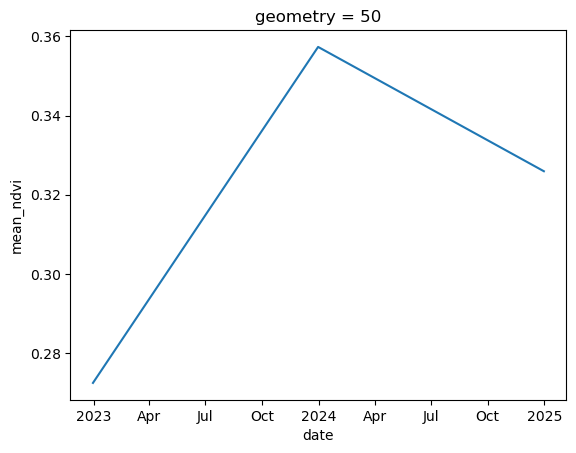

In [18]:
zs_xr_annmean = zs_xr.resample(date="YE").mean()
zs_xr_annmean.isel(geometry=50).mean_ndvi.plot()